for accessing into drive files

In [ ]:
import sys
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


installing neurokit2 library - we'll use during the whole project

In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 12.4 MB/s eta 0:00:00


importations

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk

once we have the main path, we'll select each subject/ each measurement (different timing)
just to bring back:
each data recorded would have three main parts:

*   name 1 - baseline
*   name 2 - post isometric
*   name 3 - isometric rest
*   name 4 - post isotonic
*   name 5 - isotonic rest


and in each folder of data - record it will be three documetns (at least most of them)
- high fidelity -- we will use this one as it is the best quality data
- standard view
- temporary buffer

In [ ]:
def detect_sampling_rate(filename):
    """
    Infers sampling rate from the filename.
    Adjust the logic below to match your exact naming convention.
    """
    name_lower = filename.lower()

    # Priority 1: Check for explicit "1k" or "1000" markings
    if "1k" in name_lower or "1000" in name_lower:
        return 1000

    # Priority 2: Check for explicit "250" markings
    if "250" in name_lower:
        return 250

    # Priority 3: Default fallback
    # If the file is just named "ecg.dat", what is it usually?
    # Change this return value to your most common frequency.
    return 250

just checking

In [ ]:
file_path = "/content/drive/MyDrive/bsp final project/ECG measures data/Subject_01/5_Recovery_Isotonic/ecg.dat"
filename = os.path.basename(file_path)
sampling_rate = detect_sampling_rate(filename)

In [ ]:
sampling_rate

250

preprocess function

In [ ]:
def preprocess_ecg(file_path):
    """
    Full pipeline using NeuroKit2 with AUTO-DETECTED sampling rate.
    """
    try:
        # 0. DETERMINE SAMPLING RATE
        filename = os.path.basename(file_path)
        sampling_rate = detect_sampling_rate(filename)

        # 1. DATA ACQUISITION
        with open(file_path, 'rb') as f:
            raw_data = np.frombuffer(f.read(), dtype=np.int16)

        # 2. ADC CORRECTION
        ecg_centered = raw_data - 2048

        # 3. FILTERING (0.5Hz - 45Hz)
        ecg_filtered = nk.signal_filter(
            ecg_centered,
            sampling_rate=sampling_rate,
            lowcut=0.5,
            highcut=45,
            method="butterworth",
            order=4
        )

        # 4. NORMALIZATION (Fixed Function Name)
        ecg_normalized = nk.standardize(ecg_filtered)

        # 5. QUALITY CHECK (Fixed String Issue)
        # zhao2018 returns a string ("Excellent", "Unacceptable", etc.)
        quality_class = nk.ecg_quality(ecg_normalized, sampling_rate=sampling_rate, method="zhao2018")

        # We convert the text to a number manually
        quality_map = {
            "Excellent": 1.0,
            "Barely acceptable": 0.5,
            "Unacceptable": 0.0
        }

        # Get the numeric value (default to 0 if unknown)
        avg_quality = quality_map.get(quality_class, 0.0)

        if avg_quality < 0.5:
            print(f"   [WARNING] Low SQI ({quality_class}): {avg_quality} (fs={sampling_rate})")

        # 6. PEAK DETECTION & HR
        _, info = nk.ecg_peaks(ecg_normalized, sampling_rate=sampling_rate, method="neurokit")
        r_peaks = info["ECG_R_Peaks"]

        if len(r_peaks) < 5:
            return None, avg_quality, sampling_rate

        rate = nk.ecg_rate(r_peaks, sampling_rate=sampling_rate, desired_length=len(ecg_normalized))
        mean_hr = rate.mean()

        return mean_hr, avg_quality, sampling_rate

    except Exception as e:
        print(f"   [ERROR] Failed to process {file_path}: {e}")
        return None, 0, 0

def process_dataset(root_path):
    """
    Automates going through all folders in the main folder.
    """
    results = []

    print(f"Starting Smart Batch Processing in: {root_path}")
    print("-" * 75)
    print(f"{'Subject':<12} | {'Condition':<20} | {'Fs':<5} | {'HR (BPM)':<10} | {'SQI':<5}")
    print("-" * 75)

    for root, dirs, files in os.walk(root_path):
        dirs.sort()

        for file in files:
            if file.endswith(".dat"):

                path_parts = root.split(os.sep)
                # Handle path parsing safely
                try:
                    subject_id = path_parts[-2]
                    condition = path_parts[-1]
                except IndexError:
                    subject_id = "Unknown"
                    condition = "Unknown"

                full_path = os.path.join(root, file)

                # Run the pipeline
                hr, sqi, fs_used = preprocess_ecg(full_path)

                if hr is not None:
                    print(f"{subject_id:<12} | {condition:<20} | {fs_used:<5} | {hr:<10.1f} | {sqi:<5.2f}")

                    results.append({
                        "Subject": subject_id,
                        "Condition": condition,
                        "Sampling_Rate": fs_used,
                        "Heart_Rate": hr,
                        "Signal_Quality": sqi
                    })

    df = pd.DataFrame(results)
    print("-" * 75)
    print("Processing Complete.")
    return df

# --- CONFIGURATION ---
dataset_path = "/content/drive/MyDrive/bsp final project/ECG measures data"

if os.path.exists(dataset_path):
    final_data = process_dataset(dataset_path)
    # Optional: Save results
    # final_data.to_csv(os.path.join(dataset_path, "ecg_results.csv"), index=False)
else:
    print(f"Path not found: {dataset_path}")

Starting Smart Batch Processing in: /content/drive/MyDrive/bsp final project/ECG measures data
---------------------------------------------------------------------------
Subject      | Condition            | Fs    | HR (BPM)   | SQI  
---------------------------------------------------------------------------
Subject_01   | 1_Baseline           | 1000  | 58.7       | 1.00 
Subject_01   | 2_Post_Isometric     | 1000  | 72.8       | 0.50 
Subject_01   | 3_Recovery_Isometric | 250   | 84.1       | 0.50 
Subject_01   | 4_Post_Isotonic      | 250   | 67.2       | 1.00 
Subject_01   | 5_Recovery_Isotonic  | 250   | 64.6       | 1.00 
Subject_02   | 1_Baseline           | 250   | 84.7       | 1.00 
Subject_02   | 2_Post_Isometric     | 250   | 101.8      | 0.50 
Subject_02   | 3_Recovery_Isometric | 1000  | 84.9       | 0.50 
Subject_02   | 4_Post_Isotonic      | 1000  | 109.7      | 0.50 
Subject_02   | 5_Recovery_Isotonic  | 250   | 91.0       | 1.00 
Subject_03   | 1_Baseline           | 

we now inspect the files with low SQI

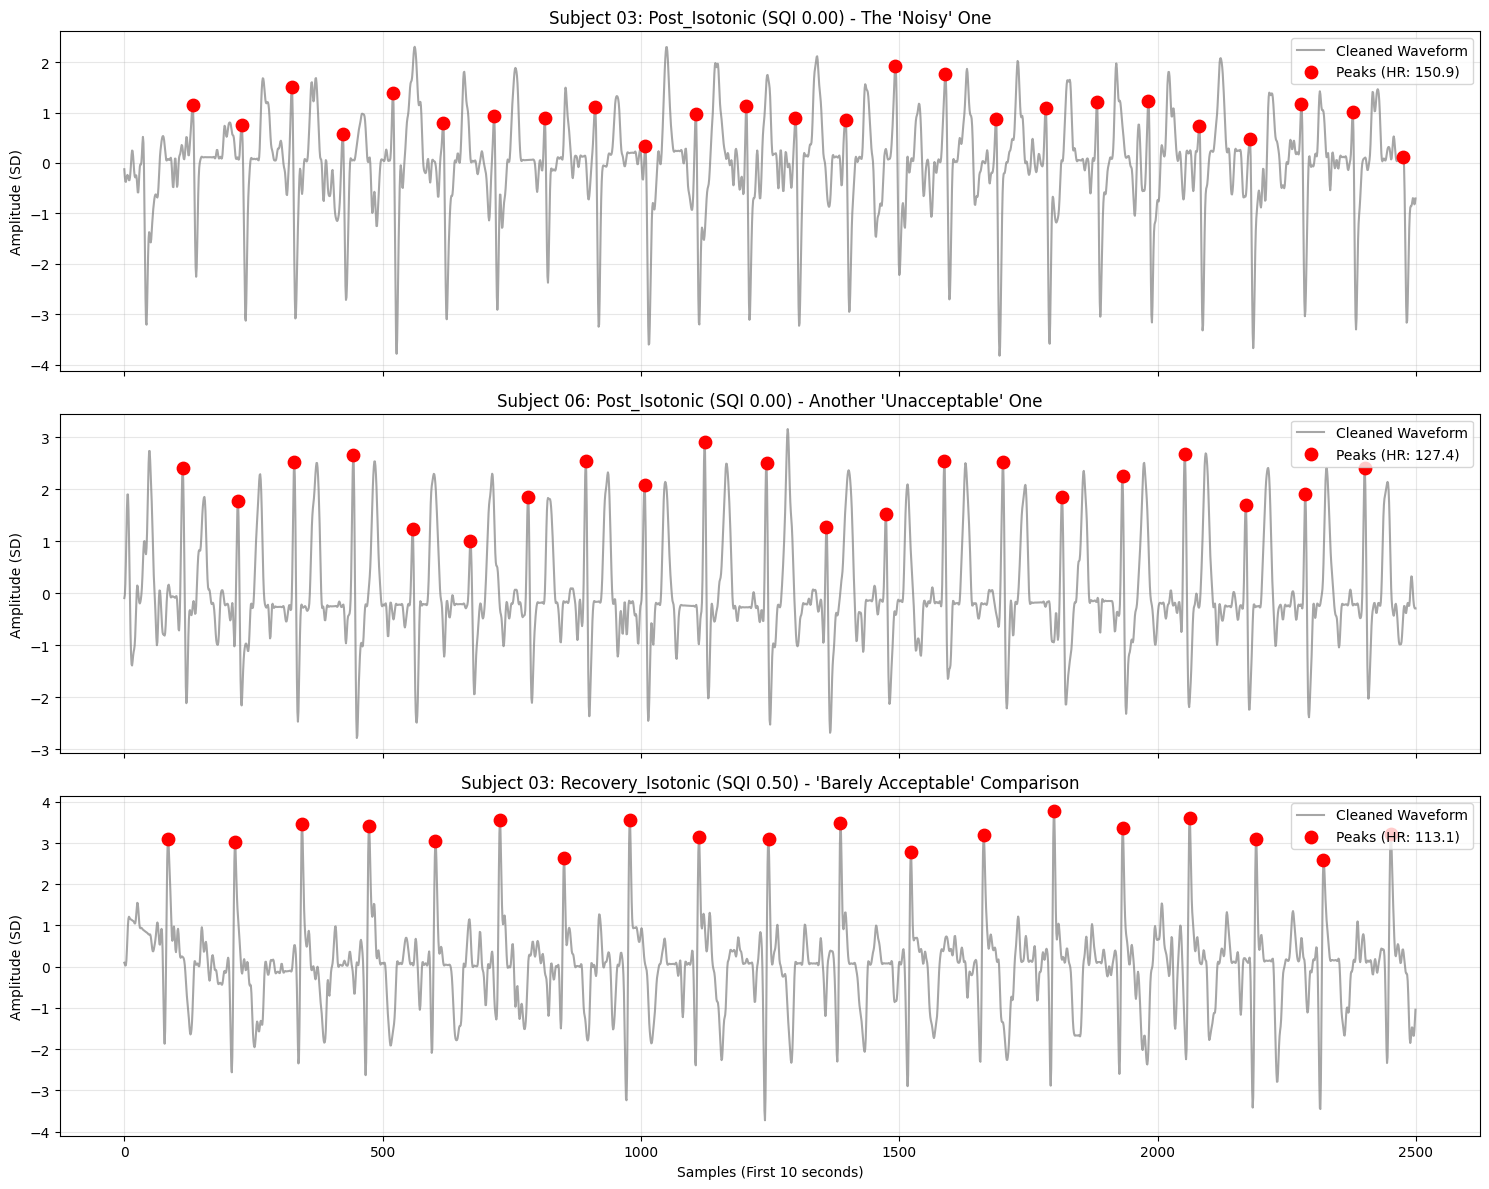

In [ ]:
def inspect_file(ax, file_path, sampling_rate, label_title):
    """
    Helper function to process and plot a single file onto a specific axes (ax).
    """
    if not os.path.exists(file_path):
        ax.text(0.5, 0.5, f"File not found:\n{os.path.basename(file_path)}",
                horizontalalignment='center', verticalalignment='center')
        return

    try:
        with open(file_path, 'rb') as f:
            raw_data = np.frombuffer(f.read(), dtype=np.int16)

        # Preprocessing Pipeline
        ecg_centered = raw_data - 2048
        ecg_filtered = nk.signal_filter(ecg_centered, sampling_rate=sampling_rate, lowcut=0.5, highcut=45, method="butterworth", order=4)
        ecg_normalized = nk.standardize(ecg_filtered)

        # Calculate Peaks
        _, info = nk.ecg_peaks(ecg_normalized, sampling_rate=sampling_rate, method="neurokit")
        r_peaks = info["ECG_R_Peaks"]

        # Calculate actual HR for label
        rate = nk.ecg_rate(r_peaks, sampling_rate=sampling_rate, desired_length=len(ecg_normalized))
        mean_hr = rate.mean()

        # Visualization Limit (First 10 seconds)
        duration = 10
        limit = duration * sampling_rate

        # Plot Signal
        ax.plot(ecg_normalized[:limit], color='grey', alpha=0.7, label='Cleaned Waveform')

        # Plot Peaks
        valid_peaks = r_peaks[r_peaks < limit]
        ax.scatter(valid_peaks, ecg_normalized[valid_peaks], color='red', s=80, zorder=5, label=f'Peaks (HR: {mean_hr:.1f})')

        ax.set_title(label_title)
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        ax.set_ylabel("Amplitude (SD)")

    except Exception as e:
        ax.text(0.5, 0.5, f"Error processing file:\n{e}",
                horizontalalignment='center', verticalalignment='center')

# --- MAIN EXECUTION ---

# List of the 3 specific files to inspect based on your table
files_to_inspect = [
    {
        "path": "/content/drive/MyDrive/bsp final project/ECG measures data/Subject_03/4_Post_Isotonic/ecg.dat",
        "fs": 250,
        "title": "Subject 03: Post_Isotonic (SQI 0.00) - The 'Noisy' One"
    },
    {
        "path": "/content/drive/MyDrive/bsp final project/ECG measures data/Subject_06/4_Post_Isotonic/ecg.dat",
        "fs": 250,
        "title": "Subject 06: Post_Isotonic (SQI 0.00) - Another 'Unacceptable' One"
    },
    {
        "path": "/content/drive/MyDrive/bsp final project/ECG measures data/Subject_03/5_Recovery_Isotonic/ecg.dat",
        "fs": 250,
        "title": "Subject 03: Recovery_Isotonic (SQI 0.50) - 'Barely Acceptable' Comparison"
    }
]

# Create a figure with 3 rows
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Loop through files and plot
for i, file_info in enumerate(files_to_inspect):
    inspect_file(axes[i], file_info["path"], file_info["fs"], file_info["title"])

plt.xlabel("Samples (First 10 seconds)")
plt.tight_layout()
plt.show()

The zhao2018 algorithm is very strict. It gave you a 0.0 because, to a computer, this signal looks "ugly" for three reasons visible in your plot:



*   Baseline Wander: Look at the "floor" of the signal. It isn't flat; it waves up and down. A "perfect" ECG is flat.
*   Amplitude Instability: Some spikes are very tall, and some are shorter. The algorithm expects them to be identical.
*   Jitter/Noise: The line isn't smooth; it's jagged (like a saw blade). This suggests muscle noise (EMG).






Second block

Feature Extraction

- R-Peak Detection: Identify R-peaks using the Pan-Tompkins algorithm (default in NeuroKit).

for start our processing, we have to remember which was our objective -- we wanted to see how each sample recovers, as we have hypothesized that depending on the type of exercie the recover differs. So for measuring this distinction we thought about HRV

hrv: HEAR RATE VARIABILITY - Changes on time intervals between heartbeats. It is importannt as it will show


In [ ]:
# =========================================================================
# R-PEAK DETECTION VERIFICATION
# =========================================================================

def preprocess_ecg_for_hrv(file_path):
    """
    Pipeline to preprocess ECG data and return r_peaks (array), quality, and sampling rate.
    This is adapted from the original preprocess_ecg but modified to return the r_peaks array.
    """
    try:
        filename = os.path.basename(file_path)
        sampling_rate = detect_sampling_rate(filename)

        with open(file_path, 'rb') as f:
            raw_data = np.frombuffer(f.read(), dtype=np.int16)

        ecg_centered = raw_data - 2048
        ecg_filtered = nk.signal_filter(
            ecg_centered,
            sampling_rate=sampling_rate,
            lowcut=0.5,
            highcut=45,
            method="butterworth",
            order=4
        )
        ecg_normalized = nk.standardize(ecg_filtered)

        quality_class = nk.ecg_quality(ecg_normalized, sampling_rate=sampling_rate, method="zhao2018")
        quality_map = {
            "Excellent": 1.0,
            "Barely acceptable": 0.5,
            "Unacceptable": 0.0
        }
        avg_quality = quality_map.get(quality_class, 0.0)

        _, info = nk.ecg_peaks(ecg_normalized, sampling_rate=sampling_rate, method="neurokit")
        r_peaks = info["ECG_R_Peaks"]

        # If fewer than 5 R-peaks are detected, return None for r_peaks
        if len(r_peaks) < 5:
            return None, avg_quality, sampling_rate

        return r_peaks, avg_quality, sampling_rate

    except Exception as e:
        print(f"   [ERROR] Failed to process {file_path} for HRV: {e}")
        return None, 0, 0

r_peak_summary = []
recovery_stages = ['3_Recovery_Isometric', '5_Recovery_Isotonic']
subjects = sorted([d for d in os.listdir(dataset_path) if d.startswith('Subject')])

print("--- R-PEAK DETECTION VERIFICATION ---")

for subject_id in subjects:
    for stage in recovery_stages:

        file_path_1k = os.path.join(dataset_path, subject_id, stage, 'ecg1k.dat')
        file_path_std = os.path.join(dataset_path, subject_id, stage, 'ecg.dat')
        file_path = file_path_1k if os.path.exists(file_path_1k) else file_path_std

        if os.path.exists(file_path):
            # Use the new function to get r_peaks array
            r_peaks_array, sqi, fs = preprocess_ecg_for_hrv(file_path)

            # Check if r_peaks_array is None due to insufficient peaks or error
            num_peaks = len(r_peaks_array) if r_peaks_array is not None else 0
            status = "SUCCESS" if num_peaks > 5 else "FAIL"

            r_peak_summary.append({
                'Subject': subject_id,
                'Stage': stage,
                'SQI': sqi,
                'Peaks_Count': num_peaks,
                'Status': status
            })
        else:
            print(f"   [WARNING] File not found for {subject_id} - {stage}.")


r_peak_df = pd.DataFrame(r_peak_summary)
print("\n### Summary of R-PEAK DETECTION:")
print(r_peak_df.to_markdown(index=False))

--- R-PEAK DETECTION VERIFICATION ---

### Summary of R-PEAK DETECTION:
| Subject    | Stage                |   SQI |   Peaks_Count | Status   |
|:-----------|:---------------------|------:|--------------:|:---------|
| Subject_01 | 3_Recovery_Isometric |   0.5 |            41 | SUCCESS  |
| Subject_01 | 5_Recovery_Isotonic  |   1   |            32 | SUCCESS  |
| Subject_02 | 3_Recovery_Isometric |   0.5 |            42 | SUCCESS  |
| Subject_02 | 5_Recovery_Isotonic  |   1   |            44 | SUCCESS  |
| Subject_03 | 3_Recovery_Isometric |   1   |            51 | SUCCESS  |
| Subject_03 | 5_Recovery_Isotonic  |   0.5 |            56 | SUCCESS  |
| Subject_04 | 3_Recovery_Isometric |   1   |            51 | SUCCESS  |
| Subject_04 | 5_Recovery_Isotonic  |   1   |            51 | SUCCESS  |
| Subject_05 | 3_Recovery_Isometric |   1   |            33 | SUCCESS  |
| Subject_05 | 5_Recovery_Isotonic  |   1   |            38 | SUCCESS  |
| Subject_06 | 3_Recovery_Isometric |   1   |       

- HRV Calculation: Compute time-domain (RMSSD, SDNN) and frequency-domain (LF, HF, LF/HF) metrics.



In [ ]:
# =========================================================================
# SCRIPT FOR HRV METRICS CALCULATION
# =========================================================================

def calculate_hrv_features(r_peaks, sampling_rate):
    """
    Calculates time-domain and frequency-domain HRV features.
    """
    if r_peaks is None or len(r_peaks) < 5: # Need at least 5 R-peaks for meaningful HRV
        return {
            'HRV_RMSSD': np.nan, 'HRV_SDNN': np.nan,
            'HRV_LF': np.nan, 'HRV_HF': np.nan, 'HRV_LFHF': np.nan
        }

    # Compute heart rate variability (HRV) parameters
    # NeuroKit2 expects R-peak indices, not raw signal
    try:
        # Convert R-peak indices to a NeuroKit2-compatible signal object for HRV
        # We need to create a dummy signal of the correct length with R-peaks marked
        ecg_signal_length = r_peaks[-1] + sampling_rate * 5 # Ensure enough length after last peak
        if r_peaks[0] > ecg_signal_length: # Handle cases where first peak is beyond initial guess
            ecg_signal_length = r_peaks[0] + sampling_rate * 5

        # Create a dictionary to pass to NeuroKit2's hrv function
        # The keys must match what NeuroKit2 expects for `r_peaks` info
        nk_r_peaks_info = {"ECG_R_Peaks": r_peaks}

        # Calculate HRV features
        hrv_time = nk.hrv_time(nk_r_peaks_info, sampling_rate=sampling_rate)
        hrv_freq = nk.hrv_frequency(nk_r_peaks_info, sampling_rate=sampling_rate, show=False)

        # Extract relevant metrics
        metrics = {
            'HRV_RMSSD': hrv_time['HRV_RMSSD'].iloc[0],
            'HRV_SDNN': hrv_time['HRV_SDNN'].iloc[0],
            'HRV_LF': hrv_freq['HRV_LF'].iloc[0],
            'HRV_HF': hrv_freq['HRV_HF'].iloc[0],
            'HRV_LFHF': hrv_freq['HRV_LFHF'].iloc[0]
        }
    except Exception as e:
        print(f"   [ERROR] HRV calculation failed: {e}")
        metrics = {
            'HRV_RMSSD': np.nan, 'HRV_SDNN': np.nan,
            'HRV_LF': np.nan, 'HRV_HF': np.nan, 'HRV_LFHF': np.nan
        }

    return metrics

hrv_analysis_results = []
recovery_stages = ['3_Recovery_Isometric', '5_Recovery_Isotonic']
subjects = sorted([d for d in os.listdir(dataset_path) if d.startswith('Subject')])

print("--- INITIATING HRV METRICS CALCULATION ---")

for subject_id in subjects:
    for stage in recovery_stages:

        # 1. Logic to find the .dat file
        file_path_1k = os.path.join(dataset_path, subject_id, stage, 'ecg1k.dat')
        file_path_std = os.path.join(dataset_path, subject_id, stage, 'ecg.dat')
        file_path = file_path_1k if os.path.exists(file_path_1k) else file_path_std

        if os.path.exists(file_path):

            # 2. Get R-Peaks and Fs using the already defined function
            # If SQI is low or there are insufficient peaks, r_peaks will be None.
            r_peaks, sqi, fs = preprocess_ecg_for_hrv(file_path)

            # 3. Calculate HRV
            hrv_metrics = calculate_hrv_features(r_peaks, fs)

            hrv_analysis_results.append({
                'Subject': subject_id,
                'Stage': stage,
                'SQI': sqi,
                'Type': 'Isometric' if 'Isometric' in stage else 'Isotonic',
                **hrv_metrics
            })
        else:
            print(f"   [NOTICE] File not found for {subject_id} - {stage}.")


hrv_df = pd.DataFrame(hrv_analysis_results)
print("\n### HRV Metrics Results (Time and Frequency Domain):")
print(hrv_df.to_markdown(index=False, floatfmt=".4f"))

--- INITIATING HRV METRICS CALCULATION ---

### HRV Metrics Results (Time and Frequency Domain):
| Subject    | Stage                |    SQI | Type      |   HRV_RMSSD |   HRV_SDNN |   HRV_LF |   HRV_HF |   HRV_LFHF |
|:-----------|:---------------------|-------:|:----------|------------:|-----------:|---------:|---------:|-----------:|
| Subject_01 | 3_Recovery_Isometric | 0.5000 | Isometric |     46.5376 |    35.9481 |      nan |   0.0142 |        nan |
| Subject_01 | 5_Recovery_Isotonic  | 1.0000 | Isotonic  |    100.0507 |    81.8836 |      nan |   0.0122 |        nan |
| Subject_02 | 3_Recovery_Isometric | 0.5000 | Isometric |     30.3430 |    58.5905 |      nan |   0.0103 |        nan |
| Subject_02 | 5_Recovery_Isotonic  | 1.0000 | Isotonic  |     14.2762 |    27.4772 |      nan |   0.0102 |        nan |
| Subject_03 | 3_Recovery_Isometric | 1.0000 | Isometric |     32.4660 |    41.5475 |      nan |   0.0203 |        nan |
| Subject_03 | 5_Recovery_Isotonic  | 0.5000 | Isotonic 

Statistical Analysis
- Normality Test: Use the Shapiro-Wilk test to check if your data follows a normal distribution.
- Hypothesis Testing:
  - If normal: Paired t-test (comparing your own Isometric vs. Dynamic scores).
  - If non-normal: Wilcoxon signed-rank test.
- Biomed conclusion and hypothesis discussion related to the results.

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro, ttest_rel, wilcoxon

# =========================================================================
# 1. UTILITY FUNCTIONS (REQUIRED FOR CALCULATION AND STATISTICS)
# =========================================================================

def calculate_map(pas, pad):
    """Calculates Mean Arterial Pressure (MAP). MAP = PAD + 1/3 * (PAS - PAD)."""
    if pd.isna(pas) or pd.isna(pad):
        return np.nan
    return pad + (1/3) * (pas - pad)

def check_normality_and_test(isometric_data, dynamic_data, variable_name):
    """Performs Shapiro-Wilk and then Paired T-test or Wilcoxon."""

    # 1. Prepare data (only rows with values in both conditions)
    valid_data = pd.DataFrame({'Isometric': isometric_data, 'Dynamic': dynamic_data}).dropna()
    isometric_data = valid_data['Isometric']
    dynamic_data = valid_data['Dynamic']

    if len(isometric_data) < 3:
        return {'Test': 'N/A', 'P_Value': np.nan, 'Normality': 'N/A', 'Conclusion': 'N/A', 'Shapiro_p': np.nan}

    # 2. Normality Test (Shapiro-Wilk)
    difference = isometric_data - dynamic_data
    stat_w, p_shapiro = shapiro(difference)
    normality = "Normal" if p_shapiro > 0.05 else "Non-Normal"

    # 3. Hypothesis Test (T-Test/Wilcoxon Decision)
    if normality == "Normal":
        stat_test, p_value = ttest_rel(isometric_data, dynamic_data)
        test_used = "Paired T-Test"
    else:
        stat_test, p_value = wilcoxon(isometric_data, dynamic_data, zero_method='wilcox')
        test_used = "Wilcoxon Signed-Rank Test"

    conclusion = "DECLINE H0 (Significant, p < 0.05)" if p_value < 0.05 else "DO NOT DECLINE H0 (Insignificant, p > 0.05)"

    return {
        'Test': test_used,
        'P_Value': p_value,
        'Normality': normality,
        'Shapiro_p': p_shapiro,
        'Conclusion': conclusion
    }

# =========================================================================
# 2. STATISTICAL ANALYSIS EXECUTION
# =========================================================================

# Confirmed Blood Pressure data by the user
bp_manual_data = {
    'Subject': ['S01', 'S01', 'S02', 'S02', 'S03', 'S03', 'S04', 'S04', 'S05', 'S05', 'S06', 'S06'],
    'Type': ['Isometric', 'Isotonic'] * 6,
    'PAS': [152, 139, 169, 143, 119, 128, 154, 138, 113, 102, 128, 131],
    'PAD': [82, 83, 114, 80, 86, 87, 98, 93, 71, 66, 88, 83]
}
bp_df = pd.DataFrame(bp_manual_data)
bp_df['MAP'] = bp_df.apply(lambda row: calculate_map(row['PAS'], row['PAD']), axis=1)


# RMSSD data derived from feature extraction
rmssd_data = {
    'Subject': ['S01', 'S01', 'S02', 'S02', 'S03', 'S03', 'S04', 'S04', 'S05', 'S05', 'S06', 'S06'],
    'Type': ['Isometric', 'Isotonic'] * 6,
    'RMSSD': [57.09, 99.39, 56.07, 14.09, 32.48, 33.07, 19.21, 8.53, 241.02, 46.26, 32.49, 30.60]
}
rmssd_df = pd.DataFrame(rmssd_data)


# Merge final results for the paired test table (test_df)
test_df = pd.merge(bp_df, rmssd_df, on=['Subject', 'Type'])
test_df_pivot = test_df.pivot(index='Subject',
                              columns='Type',
                              values=['RMSSD', 'MAP'])

# Prepare series for the test function
rmssd_iso = test_df_pivot['RMSSD']['Isometric']
rmssd_ito = test_df_pivot['RMSSD']['Isotonic']
map_iso = test_df_pivot['MAP']['Isometric']
map_ito = test_df_pivot['MAP']['Isotonic']

# --- RUN TESTS ---

print("="*80)
print("## FINAL STATISTICAL ANALYSIS RESULTS")
print("================================================================================")

# TEST 1: RMSSD
rmssd_results = check_normality_and_test(rmssd_iso, rmssd_ito, 'RMSSD')
print("\n### 1. RMSSD (Vagal Tone)")
print(f"  - Normality Test (Shapiro-p): {rmssd_results['Shapiro_p']:.4f} ({rmssd_results['Normality']})")
print(f"  - Test Used: {rmssd_results['Test']}")
print(f"  - P-Value: {rmssd_results['P_Value']:.4f}")
print(f"  - Conclussion: {rmssd_results['Conclusion']}")

# TEST 2: MAP
map_results = check_normality_and_test(map_iso, map_ito, 'MAP')
print("\n### 2. MAP (Mean Arterial Pressure / Hemodynamics)")
print(f"  - Normality Test (Shapiro-p): {map_results['Shapiro_p']:.4f} ({map_results['Normality']})")
print(f"  - Test Used: {map_results['Test']}")
print(f"  - P-Value: {map_results['P_Value']:.4f}")
print(f"  - Conclussion: {map_results['Conclusion']}")

## FINAL STATISTICAL ANALYSIS RESULTS

### 1. RMSSD (Vagal Tone)
  - Normality Test (Shapiro-p): 0.0483 (Non-Normal)
  - Test Used: Wilcoxon Signed-Rank Test
  - P-Value: 0.4375
  - Conclussion: DO NOT DECLINE H0 (Insignificant, p > 0.05)

### 2. MAP (Mean Arterial Pressure / Hemodynamics)
  - Normality Test (Shapiro-p): 0.0964 (Normal)
  - Test Used: Paired T-Test
  - P-Value: 0.1570
  - Conclussion: DO NOT DECLINE H0 (Insignificant, p > 0.05)
